# (??) Dataloder -- & Dataset

**Motivation**: Create dataloaders, next I will be ready to fit. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [16]:
def soft_clamp(x: torch.Tensor, c: float = 10.0):
    return x.div(c).tanh_().mul(c)

In [20]:
sigma = torch.randn((13, 1000)) * 7

<AxesSubplot:ylabel='Count'>

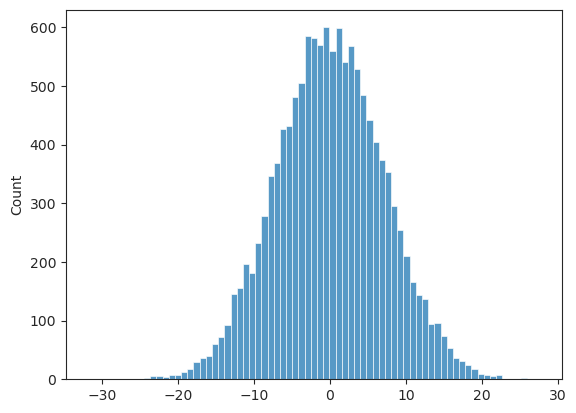

In [21]:
sns.histplot(to_np(sigma).ravel())

<AxesSubplot:ylabel='Count'>

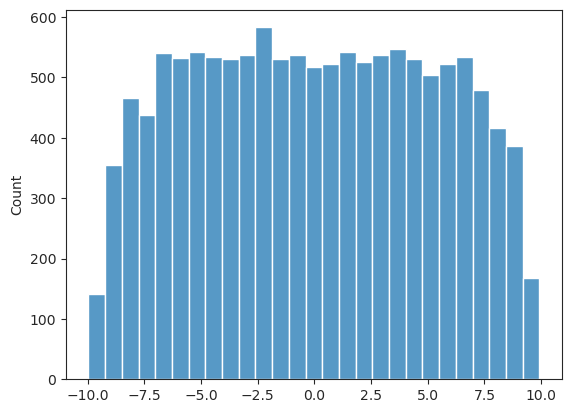

In [22]:
sns.histplot(to_np(soft_clamp(sigma)).ravel())

In [24]:
1 / np.exp(-10)

22026.465794806714

In [25]:
1 / np.exp(10)

4.539992976248485e-05

In [28]:
1 / np.exp(-7)

1096.6331584284585

## Trainer

In [10]:
from model.vae2d import VAE
from model.train import TrainerVAE
from model.configuration import ConfigVAE, ConfigTrain
from figures.fighelper import show_opticflow, show_opticflow_full
from model.common import endpoint_error, DeConv2D, Conv2D

In [19]:
def beta_anneal_linear(
		n_iters: int,
		beta: float = 1,
		anneal_portion: float = 0.3,
		constant_portion: float = 1e-2,
		min_beta: float = 1e-4, ):
	betas = np.ones(n_iters) * beta
	a = int(np.ceil(constant_portion * n_iters))
	b = int(np.ceil((constant_portion + anneal_portion) * n_iters))
	betas[:a] = min_beta
	betas[a:b] = np.linspace(min_beta, beta, b - a)
	return betas

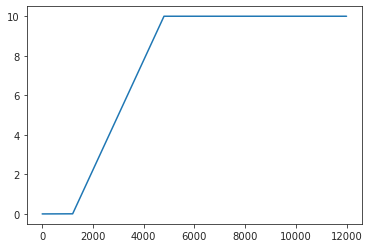

In [22]:
betas = beta_anneal_linear(12000, 10, 0.3, 1e-1, 25e-7)
plt.plot(betas)

In [23]:
betas

array([2.5e-06, 2.5e-06, 2.5e-06, ..., 1.0e+01, 1.0e+01, 1.0e+01])

In [3]:
a = '/home/hadi/Desktop/sub-SLC04_ses-1_run-7_task-rest_space-CCF2d_desc-preproc_ca2.npy'
a = np.load(a)

In [4]:
a.shape

(540, 5999)

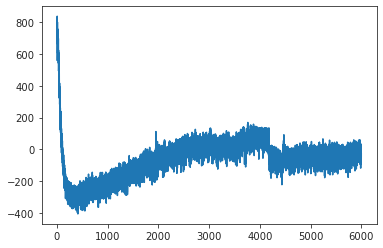

In [6]:
plt.plot(np.nanmean(a, 0))

In [ ]:
beta = kl_coeff(
    step=gstep,
    total_step=self.cfg.kl_anneal_portion * kwargs['n_iters_tot'],
    constant_step=self.cfg.kl_const_portion * kwargs['n_iters_tot'],
    min_kl_coeff=self.cfg.kl_const_coeff,
)

In [21]:
def kl_coeff(step, total_step, constant_step, min_kl_coeff):
	return max(min((step - constant_step) / total_step, 1.0), min_kl_coeff)

In [22]:
n_iters = 120000
rrr = []
for gstep in range(n_iters):
    rrr.append(kl_coeff(gstep, 0.3 * n_iters, 0.1 * n_iters, 1e-2))

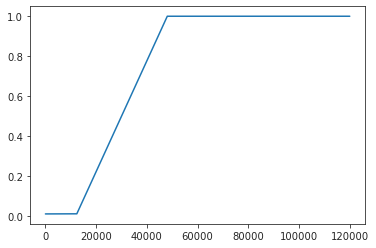

In [23]:
plt.plot(rrr)

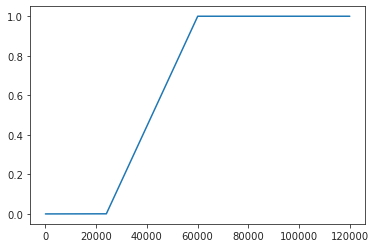

In [37]:
bbb = beta_anneal(n_iters, 0.3, 0.2)
plt.plot(bbb)

In [14]:
x = torch.randn((128, 2, 19, 19))
y = torch.randn((128, 2, 19, 19))
norm = torch.linalg.norm(x, dim=1).sum(-1).sum(-1)

In [15]:
norm

tensor([425.6809, 441.2263, 470.1122, 458.8769, 467.1743, 454.2744, 450.2484,
        442.3687, 451.3485, 472.5881, 467.1559, 460.9863, 459.0367, 454.2975,
        455.9691, 482.7391, 453.0619, 470.9553, 445.0170, 438.6615, 438.9612,
        436.8954, 457.9799, 442.1515, 449.8611, 431.0654, 449.2562, 442.6693,
        443.5562, 457.8253, 449.5399, 424.6128, 427.4868, 439.3514, 472.6831,
        456.6191, 452.1575, 451.0710, 463.9073, 423.3181, 445.8593, 446.9283,
        460.7754, 456.8409, 442.0953, 451.1641, 437.1913, 455.8188, 456.3357,
        440.3274, 439.5856, 452.8519, 458.6751, 437.0970, 460.5370, 437.4661,
        446.1432, 459.3324, 454.8264, 452.4272, 437.9156, 443.3121, 456.5600,
        457.0146, 456.4915, 450.8528, 455.5231, 446.6976, 442.8574, 446.8372,
        462.8190, 470.3230, 447.0914, 451.3150, 426.6937, 461.3628, 472.3909,
        438.2449, 450.2120, 433.0136, 455.0769, 450.7665, 456.1589, 457.1379,
        439.0401, 458.6666, 466.7363, 447.4090, 451.8221, 430.88

In [16]:
torch.sum(torch.linalg.norm(
    x, dim=1), dim=[1, 2])

tensor([425.6809, 441.2263, 470.1122, 458.8769, 467.1743, 454.2744, 450.2484,
        442.3687, 451.3485, 472.5881, 467.1559, 460.9863, 459.0367, 454.2975,
        455.9691, 482.7391, 453.0620, 470.9553, 445.0170, 438.6615, 438.9613,
        436.8954, 457.9799, 442.1514, 449.8611, 431.0654, 449.2562, 442.6693,
        443.5562, 457.8253, 449.5400, 424.6128, 427.4868, 439.3514, 472.6831,
        456.6191, 452.1575, 451.0710, 463.9073, 423.3181, 445.8593, 446.9284,
        460.7754, 456.8408, 442.0953, 451.1640, 437.1913, 455.8188, 456.3357,
        440.3274, 439.5856, 452.8519, 458.6751, 437.0970, 460.5369, 437.4661,
        446.1433, 459.3324, 454.8264, 452.4272, 437.9156, 443.3120, 456.5600,
        457.0147, 456.4914, 450.8528, 455.5231, 446.6976, 442.8574, 446.8373,
        462.8190, 470.3230, 447.0915, 451.3150, 426.6937, 461.3627, 472.3909,
        438.2449, 450.2119, 433.0137, 455.0768, 450.7665, 456.1589, 457.1379,
        439.0401, 458.6666, 466.7363, 447.4090, 451.8221, 430.88

In [17]:
cfg = ConfigVAE(full=False)

In [25]:

alpha

tensor([1.0000, 1.4142, 1.4142, 2.0000, 2.0000, 2.0000, 2.0000])

In [29]:
for fun in ['equal', 'linear', 'sqrt', 'square']:
    alpha = kl_balancer_coeff(
        groups=cfg.groups,
        # device=self.device,
        fun=fun,
    )
    print(fun, alpha)

equal tensor([1., 1., 1., 1., 1., 1., 1.])

linear tensor([1., 2., 2., 4., 4., 4., 4.])

sqrt tensor([1.0000, 1.4142, 1.4142, 2.0000, 2.0000, 2.0000, 2.0000])

square tensor([1., 2., 2., 4., 4., 4., 4.])

In [91]:
def beta_cycle_cosine(
	n_iters: int,
	start: float = 0.0,
	stop: float = 1.0,
	n_cycles: int = 4,
	ratio: float = 0.5, ):
	period = n_iters / n_cycles
	step = (stop-start) / (period*ratio)
	beta = np.ones(n_iters)
	for c in range(n_cycles):
		v, i = start, 0
		while v <= stop:
			idx = int(i+c*period)
			val = 0.5 * (1 - np.cos(v*np.pi))
			beta[idx] = val
			v += step
			i += 1
	return beta

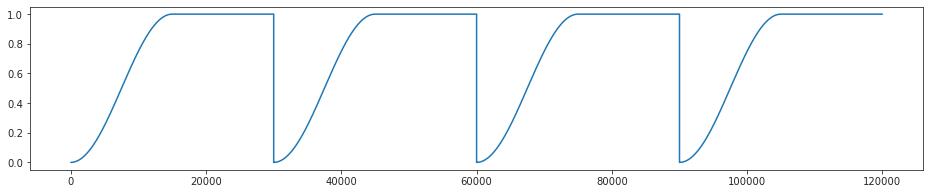

In [92]:
beta = frange_cycle_cosine(120000, 0, 1, 4, 0.5)

fig, ax = create_figure(1, 1, (16, 3))
plt.plot(beta);

In [ ]:
epochs = 1000


In [ ]:
self.beta = beta_cycle_cosine(
    n_iters=self.cfg.epochs * len(self.dl_trn),
    n_cycles=8,
)

In [30]:
epe = endpoint_error(x, y)

In [31]:
epe.mean()

tensor(639.8550)

In [32]:
l2_loss = nn.MSELoss(reduction='none')
l2 = l2_loss(x, y)
l2 = torch.sum(l2, dim=[1, 2, 3])

In [33]:
l2.mean()

tensor(1447.9489)

In [25]:
torch.linalg.vector_norm(x, dim=[1, 2, 3]).pow(2)

tensor([747.6130, 733.6996, 740.8716, 821.3914, 702.4655, 705.5377, 723.1444,
        742.3929, 658.3102, 703.7510, 732.7523, 736.1699, 809.8279, 682.5543,
        743.1721, 660.1917, 782.0334, 698.3531, 739.7576, 722.3749, 771.1991,
        684.5679, 741.9361, 675.1664, 732.5316, 721.4393, 732.4322, 749.3489,
        721.2635, 672.3697, 752.2667, 737.1213, 717.1757, 747.0151, 714.4672,
        714.2298, 665.7264, 777.5353, 796.2147, 738.8734, 628.1160, 725.2769,
        750.9717, 778.9816, 699.5958, 781.1461, 793.3771, 723.9106, 704.1640,
        683.0518, 729.7271, 769.2794, 669.2621, 750.7228, 677.2388, 732.4048,
        691.7855, 690.3859, 745.3564, 646.2433, 729.8783, 718.5549, 646.8780,
        701.3270, 678.5840, 711.5289, 648.5648, 717.2763, 695.7993, 751.0055,
        722.3929, 734.4705, 712.4592, 716.6702, 803.1783, 642.2767, 770.4636,
        688.1237, 694.9170, 679.9206, 670.6030, 688.1810, 700.1636, 778.9955,
        743.0467, 766.1550, 727.5212, 797.4037, 782.4201, 774.16

In [29]:
l2_loss(x, torch.zeros_like(x)).sum(1).sum(1).sum(1)

tensor([747.6130, 733.6997, 740.8716, 821.3914, 702.4656, 705.5378, 723.1444,
        742.3928, 658.3101, 703.7509, 732.7522, 736.1699, 809.8279, 682.5544,
        743.1719, 660.1917, 782.0335, 698.3530, 739.7574, 722.3749, 771.1990,
        684.5677, 741.9362, 675.1664, 732.5316, 721.4393, 732.4323, 749.3489,
        721.2634, 672.3696, 752.2667, 737.1215, 717.1755, 747.0151, 714.4672,
        714.2299, 665.7263, 777.5354, 796.2147, 738.8735, 628.1161, 725.2769,
        750.9717, 778.9814, 699.5960, 781.1461, 793.3770, 723.9105, 704.1642,
        683.0518, 729.7271, 769.2794, 669.2621, 750.7227, 677.2388, 732.4048,
        691.7855, 690.3858, 745.3563, 646.2433, 729.8783, 718.5550, 646.8779,
        701.3271, 678.5840, 711.5290, 648.5649, 717.2763, 695.7993, 751.0054,
        722.3928, 734.4705, 712.4592, 716.6702, 803.1784, 642.2767, 770.4633,
        688.1238, 694.9171, 679.9205, 670.6030, 688.1810, 700.1637, 778.9957,
        743.0468, 766.1551, 727.5214, 797.4037, 782.4200, 774.16

In [19]:
torch.sqrt(l2.sum(1)).sum(-1).sum(-1)

tensor([629.6990, 653.1978, 628.2412, 641.8640, 655.3443, 642.1229, 652.9913,
        622.5256, 621.0876, 615.0323, 644.8344, 626.6290, 689.1006, 623.5077,
        656.3489, 661.4698, 628.4563, 615.3880, 650.4142, 630.4352, 653.6823,
        608.5909, 644.6091, 609.4150, 632.9284, 638.7201, 648.2064, 644.2236,
        643.3927, 607.4060, 649.6266, 635.3988, 621.8128, 649.2741, 640.6860,
        657.6784, 630.2331, 638.2609, 664.0980, 660.4385, 623.5651, 630.1866,
        656.7003, 678.3939, 629.5043, 636.9385, 667.6707, 614.3516, 626.7168,
        640.0151, 641.6725, 670.6664, 606.5636, 663.6094, 617.7531, 622.8126,
        636.7740, 638.4486, 650.4564, 632.2997, 649.5842, 671.8973, 646.3324,
        641.7571, 629.8871, 659.0804, 614.2552, 643.0939, 652.9941, 643.0642,
        621.7007, 655.7653, 626.8777, 658.2568, 630.8110, 617.2177, 634.2674,
        627.7083, 627.6661, 613.2363, 641.1849, 612.5842, 631.1185, 640.7504,
        638.0543, 661.9254, 614.7608, 662.5044, 667.1885, 637.86

tensor([747.6130, 733.6997, 740.8716, 821.3914, 702.4656, 705.5378, 723.1444,
        742.3928, 658.3101, 703.7509, 732.7522, 736.1699, 809.8279, 682.5544,
        743.1719, 660.1917, 782.0335, 698.3530, 739.7574, 722.3749, 771.1990,
        684.5677, 741.9362, 675.1664, 732.5316, 721.4393, 732.4323, 749.3489,
        721.2634, 672.3696, 752.2667, 737.1215, 717.1755, 747.0151, 714.4672,
        714.2299, 665.7263, 777.5354, 796.2147, 738.8735, 628.1161, 725.2769,
        750.9717, 778.9814, 699.5960, 781.1461, 793.3770, 723.9105, 704.1642,
        683.0518, 729.7271, 769.2794, 669.2621, 750.7227, 677.2388, 732.4048,
        691.7855, 690.3858, 745.3563, 646.2433, 729.8783, 718.5550, 646.8779,
        701.3271, 678.5840, 711.5290, 648.5649, 717.2763, 695.7993, 751.0054,
        722.3928, 734.4705, 712.4592, 716.6702, 803.1784, 642.2767, 770.4633,
        688.1238, 694.9171, 679.9205, 670.6030, 688.1810, 700.1637, 778.9957,
        743.0468, 766.1551, 727.5214, 797.4037, 782.4200, 774.16

In [14]:
mu = torch.randn((3, 8))
sigma = torch.randn((3, 8))

In [15]:
mu, sigma

(tensor([[ 0.1122,  0.5129, -0.4425, -2.1769, -0.8268,  0.1424,  1.5048, -1.4076],
         [ 1.0724,  1.6425, -0.2142,  0.1953, -0.5890, -0.9897,  0.7150, -0.4424],
         [-0.9415, -0.6545,  1.9329,  0.4982, -1.1759, -0.1427,  1.0383,  1.5114]]),
 tensor([[-0.4936, -0.5728,  0.6749, -0.6792, -1.3159,  0.4215, -0.8694,  0.4871],
         [ 0.2969, -0.7648,  0.4516, -0.1732,  1.0126,  0.8496, -0.5250,  0.8572],
         [ 2.3984, -0.8545, -0.1391,  0.1293, -0.5360, -0.8622,  1.4206, -0.5930]]))

In [16]:
eps = mu.mul(0).normal_()
eps

tensor([[ 0.6877, -0.1969,  0.7380, -0.2097, -0.2244,  0.0326, -0.9199, -0.0609],
        [-1.0349, -0.9747, -2.1280, -0.3248,  1.0452,  0.3964,  1.4942, -0.8744],
        [-0.4584,  0.2539, -0.8111, -0.4586,  1.4671, -1.1485, -0.1303, -1.5311]])

In [17]:
eps = mu.mul(0).normal_().mul_(sigma)
z = eps.add(mu)

In [18]:
z

tensor([[-0.0821, -0.6124,  1.0330, -2.2054, -0.1948,  0.6712,  1.1051, -1.5058],
        [ 1.1065,  1.7642, -0.7957,  0.2995,  0.3203, -1.0855,  0.8040,  0.8167],
        [ 1.9699, -1.7382,  1.9173,  0.6727, -1.1518,  1.6261,  0.1960,  1.7798]])

In [19]:
eps

tensor([[-0.1943, -1.1253,  1.4755, -0.0286,  0.6320,  0.5287, -0.3997, -0.0982],
        [ 0.0341,  0.1217, -0.5815,  0.1042,  0.9094, -0.0957,  0.0889,  1.2591],
        [ 2.9114, -1.0838, -0.0157,  0.1744,  0.0242,  1.7688, -0.8423,  0.2685]])

In [36]:
def kl_coeff(step, total_step, constant_step, min_kl_coeff):
	return max(min((step - constant_step) / total_step, 1.0), min_kl_coeff)

In [49]:
x = np.zeros(12000)
for i in range(len(x)):
    x[i] = kl_coeff(i, 0.3 * 12000, 12000 * 0.1, 0.123)

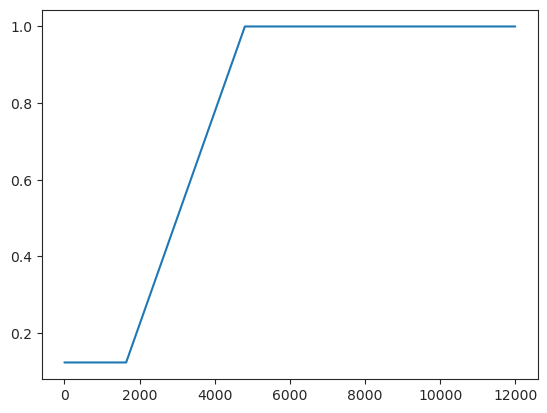

In [50]:
plt.plot(x)

In [122]:
self = tr = TrainerVAE(VAE(ConfigVAE(full=True)), ConfigTrain())

In [123]:
def beta_cycle_cosine(
		n_iters: int,
		start: float = 0.0,
		stop: float = 1.0,
		n_cycles: int = 4,
		ratio: float = 0.5,
		min_beta: float = 1e-4, ):
	period = n_iters / n_cycles
	step = (stop-start) / (period*ratio)
	beta = np.ones(n_iters)
	for c in range(n_cycles):
		v, i = start, 0
		while v <= stop:
			idx = int(i+c*period)
			val = 0.5 * (1 - np.cos(v*np.pi))
			beta[idx] = val
			v += step
			i += 1
	beta[beta < min_beta] = min_beta
	return beta

In [124]:
self.beta = beta_cycle_cosine(
    n_iters=self.cfg.epochs * len(self.dl_trn),
    n_cycles=8,
)

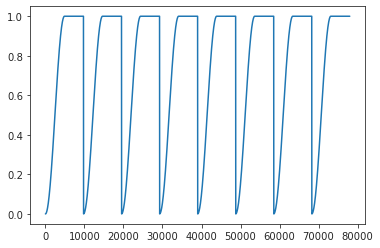

In [125]:
plt.plot(self.beta)

In [126]:
ret = []
for epoch in tqdm(range(self.cfg.epochs)):
    for i in range(len(self.dl_trn)):
        gstep = epoch * len(self.dl_trn) + i
        beta = self.beta[gstep]
        ret.append(beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [127]:
gstep

77999

In [128]:
len(self.beta)

78000

In [129]:
self.beta[1]

0.0001

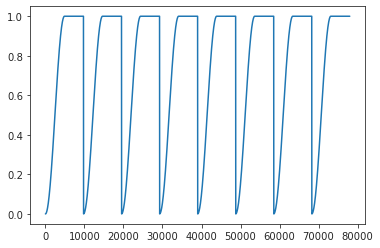

In [121]:
plt.plot(self.beta)

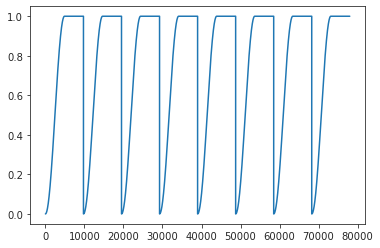

In [108]:
plt.plot(ret)

In [56]:
normalized_samples = torch.randn((13, 8))
sigma = torch.exp(torch.randn((13, 8)))

In [57]:
log_p = (
    - 0.5 * normalized_samples ** 2
    - 0.5 * np.log(2 * np.pi)
    - torch.log(sigma)
)

In [58]:
log_p

tensor([[-2.3694, -1.8308, -0.7791,  1.5293, -1.2713, -0.9764, -5.1608, -1.4846],
        [-1.5922, -2.3925, -2.3156, -1.7605, -0.2739, -1.1759, -0.9048, -0.9694],
        [-2.7857, -0.4068, -0.0667, -1.5675, -0.3610, -1.2282, -0.7611, -2.7479],
        [ 0.0368, -1.9140, -1.3561, -0.4028, -0.9015, -1.4530, -0.2992, -2.1914],
        [-0.6287, -1.6673, -1.4189, -1.7333, -0.7851, -3.1374, -1.7657, -0.5307],
        [-4.8624,  0.9339, -0.2831, -1.4632, -3.4493, -2.6331,  1.9343, -2.3632],
        [-0.0230, -1.1072, -0.4629, -2.0903, -0.8332, -1.1019,  0.3970, -0.8058],
        [-0.0238, -3.4209, -3.4497,  0.5201, -3.4146, -2.5076,  1.1838, -2.0311],
        [-2.7138, -1.5885, -1.0503,  0.0257, -2.6728, -1.8120, -3.0322, -0.1518],
        [-2.5873, -0.6933, -1.4812, -2.1539, -2.0399, -2.7781, -0.8052, -2.7126],
        [-0.3526, -1.4791, -0.6418, -0.8165,  0.3287, -2.3885, -0.9162, -0.9316],
        [-0.7125, -3.2995, -1.5600, -1.3643, -1.4540, -2.0953, -1.3327, -2.2483],
        [-1.0298

In [55]:
torch.log(sigma)

tensor([[ 0.3591,     nan, -0.9571, -1.5177,     nan, -1.6382,     nan,  0.7242],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-1.1607,  0.9695, -0.2184,     nan, -0.3224,  1.0160,     nan,     nan],
        [ 0.0538, -1.8930,  0.2184,     nan,  0.0590,     nan,     nan,     nan],
        [ 0.5252,     nan,     nan,     nan,  0.7673,     nan, -1.3828,     nan],
        [ 1.0148, -0.9996,     nan, -0.2135,     nan,     nan,     nan, -0.2802],
        [    nan,     nan, -6.1357,  0.8372,     nan,     nan, -0.2296, -0.7223],
        [-0.4775, -1.4117,     nan,     nan, -3.3619,     nan,     nan, -4.3732],
        [ 0.5700,     nan,     nan, -0.7747,     nan,     nan,     nan,     nan],
        [    nan,     nan,  0.2162,     nan,     nan,     nan,     nan,  0.2508],
        [    nan, -1.1528,     nan, -1.0758,  0.5026,     nan,     nan, -1.9246],
        [-3.1981, -1.7408,     nan,     nan,  0.4714,     nan,     nan,     nan],
        [    nan

In [160]:
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

In [184]:
q = Normal(nn.Parameter(torch.randn((3, 4))), nn.Parameter(torch.randn((3, 4)).exp()))
p = Normal(nn.Parameter(torch.randn((3, 4))), nn.Parameter(torch.randn((3, 4)).exp()))

In [185]:
kl_true = kl_divergence(q, p)
kl_true

tensor([[ 1.4999,  1.4784, 75.8491,  0.1995],
        [ 8.5944, 67.7283,  1.8588,  0.3194],
        [ 4.4265, 12.1696,  2.1257,  1.4096]], grad_fn=<MulBackward0>)

In [186]:
q.log_prob(torch.randn(3, 4))

tensor([[-1.8109, -9.1943, -1.4652, -1.8974],
        [-1.9089, -2.0395, -3.1550, -3.9428],
        [-5.3129, -2.1137, -0.5710, -6.5973]], grad_fn=<SubBackward0>)

In [190]:
q.rsample()

tensor([[ 1.9614, -0.2400,  1.9580,  1.4346],
        [ 2.3863,  2.5389,  0.5869,  1.3907],
        [ 1.2806,  2.2005, -0.4789,  0.4627]], grad_fn=<AddBackward0>)

In [187]:
qq = Normal2(q.mean, q.variance.log())
pp = Normal2(p.mean, p.variance.log())

In [188]:
qq.kl(pp)

tensor([[9.7541e+00, 3.4058e+00, 8.8346e+03, 4.2316e-01],
        [1.3991e+02, 3.6020e+03, 2.6195e+00, 5.0918e-01],
        [3.0792e+00, 4.0543e+02, 4.0167e+00, 2.6629e+00]],
       grad_fn=<SubBackward0>)

In [189]:
qq.kl_hadi(pp)

tensor([[ 1.4995,  1.4760, 75.2751,  0.1994],
        [ 8.5855, 67.5560,  1.8583,  0.3192],
        [ 4.4225, 12.1520,  2.1221,  1.4085]], grad_fn=<MulBackward0>)

In [179]:
class Normal2:
	def __init__(
			self,
			mu: torch.Tensor,
			logsigma: torch.Tensor,
			temp: float = 1.0,
			seed: int = None,
	):
		self.mu = soft_clamp(mu)
		logsigma = soft_clamp(logsigma)
		self.sigma = torch.exp(logsigma)  # + 1e-2
		# we don't need above after soft clamp (?)
		if temp != 1.0:
			self.sigma *= temp
		if seed is not None:
			self.rng = torch.Generator()
			self.rng.manual_seed(seed)
		else:
			self.rng = None

	def sample(self):
		return sample_normal(self.mu, self.sigma, self.rng)

	def log_p(self, samples: torch.Tensor):
		normalized_samples = (samples - self.mu) / self.sigma
		log_p = (
			- 0.5 * normalized_samples ** 2
			- 0.5 * np.log(2 * np.pi)
			- torch.log(self.sigma)
		)
		return log_p

	def kl(self, normal_dist):
		term1 = (self.mu - normal_dist.mu) / normal_dist.sigma
		term2 = self.sigma / normal_dist.sigma
		return 0.5 * (term1 ** 2 + term2 ** 2) - 0.5 - torch.log(term2)

	def kl_hadi(self, p):
		delta_mu = self.mu - p.mu
		delta_sigma = self.sigma / p.sigma
		return 0.5 * (
			delta_sigma -
			torch.log(delta_sigma) +
			delta_mu ** 2 / p.sigma -
			1
		)
    
def soft_clamp(x: torch.Tensor, c: float = 50.0):
	return x.div(c).tanh_().mul(c)

In [12]:
self = tr = TrainerVAE(VAE(ConfigVAE()), ConfigTrain(batch_size=128))

In [13]:
x, norm = next(iter(tr.dl_trn))
x, norm = tr.to([x, norm])

In [14]:
y, _, log_q, log_p, kl_all, kl_diag = tr.model(x)
loss_recon = endpoint_error(
    true=x, pred=y, w=1/norm)

In [15]:
loss_recon

tensor([ 45.4377, 205.4288,  46.5688,  59.2610,  49.0402,  71.2847,  73.4616,
         61.2706,  54.1703, 102.6177,  64.6650,  49.5783,  56.0723,  55.1371,
         74.4011, 175.9845,  49.9946,  53.6751,  59.3473,  66.1611,  49.1458,
         63.2466,  57.1993,  55.0466,  58.2670,  52.8819,  53.5533,  58.4538,
        143.5602,  74.1172, 102.1183,  71.7040,  64.8274,  57.0710,  55.0423,
         50.3285, 282.2430,  61.9622,  97.2113,  65.9979,  49.9359,  76.7833,
         52.9420,  64.0103,  60.7069,  46.8805,  50.1055, 180.3509,  50.5020,
        110.2339,  65.4224, 106.2291,  67.5172,  53.7452,  48.5706,  83.1084,
         60.4647,  50.1841,  60.6372,  50.0537,  56.9153,  47.4792,  52.3995,
         48.9703, 153.9743,  58.5689,  50.9976,  63.0951,  50.6682,  55.6268,
         46.0520,  76.8719,  48.9700,  49.2673,  49.3223,  67.7599,  85.2331,
         49.7888,  53.9074,  74.2478,  55.2077,  49.4101, 447.6043,  73.3690,
         60.8083,  50.5836,  47.3349,  45.3234,  51.6444,  45.22

In [17]:
gstep = 50

In [21]:
alpha = kl_balancer_coeff(
    groups=self.model.cfg.groups,
    device=self.device,
    fun='square',
)
alpha

tensor([1., 2., 2., 4., 4., 4., 4.])

In [22]:
beta = kl_coeff(
    step=gstep,
    total_step=self.cfg.kl_anneal_portion * 500 * len(self.dl_trn),
    constant_step=self.cfg.kl_const_portion * 500 * len(self.dl_trn),
    min_kl_coeff=self.cfg.kl_const_coeff,
)
balanced_kl, kl_coeffs, kl_vals = kl_balancer(
    kl_all=kl_all, coeff=beta, alpha=alpha)

In [23]:
balanced_kl

tensor([0.0031, 0.0007, 0.0015, 0.0008, 0.0024, 0.0007, 0.0011, 0.0009, 0.0009,
        0.0017, 0.0008, 0.0012, 0.0016, 0.0010, 0.0008, 0.0007, 0.0009, 0.0030,
        0.0010, 0.0008, 0.0023, 0.0008, 0.0009, 0.0036, 0.0011, 0.0011, 0.0023,
        0.0015, 0.0008, 0.0007, 0.0009, 0.0008, 0.0010, 0.0020, 0.0012, 0.0010,
        0.0007, 0.0025, 0.0008, 0.0008, 0.0009, 0.0007, 0.0009, 0.0011, 0.0009,
        0.0009, 0.0010, 0.0011, 0.0012, 0.0007, 0.0011, 0.0008, 0.0008, 0.0009,
        0.0010, 0.0007, 0.0036, 0.0057, 0.0010, 0.0013, 0.0008, 0.0072, 0.0007,
        0.0009, 0.0008, 0.0011, 0.0009, 0.0007, 0.0010, 0.0010, 0.0013, 0.0009,
        0.0011, 0.0011, 0.0012, 0.0023, 0.0006, 0.0011, 0.0017, 0.0008, 0.0012,
        0.0013, 0.0007, 0.0013, 0.0008, 0.0008, 0.0016, 0.0016, 0.0011, 0.0010,
        0.0014, 0.0018, 0.0007, 0.0010, 0.0015, 0.0010, 0.0010, 0.0008, 0.0013,
        0.0011, 0.0009, 0.0030, 0.0007, 0.0020, 0.0008, 0.0009, 0.0014, 0.0011,
        0.0015, 0.0017, 0.0009, 0.0008, 

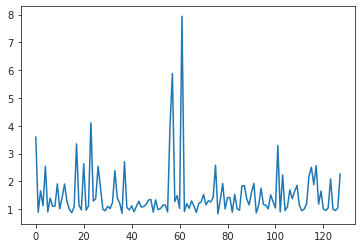

In [27]:
plt.plot(to_np(sum(kl_all)))

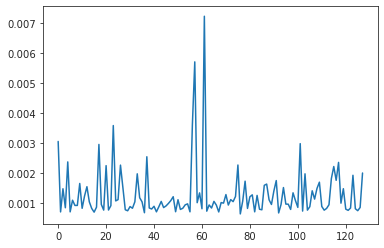

In [28]:
plt.plot(to_np(balanced_kl))

In [32]:
nelbo_batch = loss_recon + balanced_kl
nelbo_batch

tensor([ 45.4408, 205.4296,  46.5703,  59.2619,  49.0426,  71.2854,  73.4627,
         61.2715,  54.1712, 102.6193,  64.6658,  49.5795,  56.0738,  55.1382,
         74.4020, 175.9852,  49.9955,  53.6781,  59.3482,  66.1618,  49.1480,
         63.2473,  57.2003,  55.0502,  58.2681,  52.8830,  53.5556,  58.4553,
        143.5609,  74.1179, 102.1192,  71.7048,  64.8285,  57.0730,  55.0434,
         50.3296, 282.2437,  61.9647,  97.2121,  65.9987,  49.9368,  76.7840,
         52.9429,  64.0114,  60.7078,  46.8815,  50.1065, 180.3520,  50.5032,
        110.2346,  65.4235, 106.2299,  67.5181,  53.7461,  48.5716,  83.1091,
         60.4683,  50.1898,  60.6383,  50.0550,  56.9161,  47.4864,  52.4002,
         48.9713, 153.9751,  58.5700,  50.9985,  63.0958,  50.6692,  55.6278,
         46.0533,  76.8728,  48.9712,  49.2684,  49.3235,  67.7621,  85.2338,
         49.7899,  53.9092,  74.2486,  55.2089,  49.4114, 447.6050,  73.3703,
         60.8091,  50.5844,  47.3365,  45.3251,  51.6455,  45.22

In [33]:
loss = torch.mean(nelbo_batch)
loss

tensor(72.4572, grad_fn=<MeanBackward0>)

In [35]:
nelbo_batch = loss_recon.sum() + balanced_kl
nelbo_batch

tensor([9274.3564, 9274.3545, 9274.3555, 9274.3545, 9274.3555, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3555, 9274.3545, 9274.3545,
        9274.3555, 9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3564,
        9274.3545, 9274.3545, 9274.3555, 9274.3545, 9274.3545, 9274.3574,
        9274.3545, 9274.3545, 9274.3555, 9274.3555, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3555, 9274.3545, 9274.3545,
        9274.3545, 9274.3564, 9274.3545, 9274.3545, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3574, 9274.3594, 9274.3545, 9274.3545,
        9274.3545, 9274.3604, 9274.3545, 9274.3545, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545, 9274.3545,
        9274.3545, 9274.3545, 9274.3545, 9274.3555, 9274.3545, 9274.3545,
        9274.3555, 9274.3545, 9274.354

In [36]:
loss = torch.mean(nelbo_batch)
loss

tensor(9274.3555, grad_fn=<MeanBackward0>)

In [4]:
tr.cfg.epochs

1000

In [32]:
tr.cfg.eval_freq

5

In [33]:
epoch = 123

In [34]:
n_iters = len(tr.dl_trn)


In [35]:
global_step

38688

In [14]:
x, norm = next(iter(tr.dl_vld))

In [22]:
err = endpoint_error(x, 0, None)
err.shape

torch.Size([128])

In [24]:
err

tensor([132.5975,  53.5925,  72.4799, 145.3036,  85.0255,  84.6349,  96.5781,
         86.5584, 144.9209,  20.2190,  13.6957,  65.5549,  84.1360,  23.9441,
         49.3298,  14.5331, 127.2233,  87.9757,  68.8804, 108.8885,  79.6087,
         98.4160, 105.2094,  37.8709, 264.2548, 132.5681, 119.2118,  73.0115,
        150.9497,  25.5428,  19.6858,   8.9699, 136.4348,  36.9607,  40.8509,
        138.7265,  94.4150, 106.9915, 110.2774,  59.0889, 124.1433, 146.8308,
        153.7984,  66.0192,   1.7087,  59.2007, 139.8999, 152.8509, 127.4156,
         75.5292,  21.4601, 125.9101, 101.0888, 110.9665,  73.3013, 105.1366,
        151.7934,  49.2825, 104.6970,  69.5208,  87.4045, 142.3419,  19.5908,
         20.4876,  20.6781,  43.9582, 104.0770,  67.6602, 106.2190, 127.8443,
         98.9768, 154.5563,  38.7343, 115.4509,  76.6932,  72.1344,  66.3664,
         88.6815,  52.6462,  38.5949,  17.4678, 116.8431,  82.2381, 131.3993,
         57.6906, 133.3196,  53.7212, 124.5322,  95.5550,  52.34

In [25]:
norm

tensor([132.5975,  53.5925,  72.4799, 145.3036,  85.0255,  84.6349,  96.5781,
         86.5584, 144.9209,  20.2190,  13.6957,  65.5549,  84.1360,  23.9441,
         49.3298,  14.5331, 127.2233,  87.9757,  68.8804, 108.8885,  79.6087,
         98.4160, 105.2094,  37.8709, 264.2548, 132.5681, 119.2118,  73.0115,
        150.9497,  25.5428,  19.6858,   8.9699, 136.4348,  36.9607,  40.8509,
        138.7265,  94.4150, 106.9915, 110.2774,  59.0889, 124.1433, 146.8308,
        153.7984,  66.0192,   1.7087,  59.2007, 139.8999, 152.8509, 127.4156,
         75.5292,  21.4601, 125.9101, 101.0888, 110.9665,  73.3013, 105.1366,
        151.7934,  49.2825, 104.6970,  69.5208,  87.4045, 142.3419,  19.5908,
         20.4876,  20.6781,  43.9582, 104.0770,  67.6602, 106.2190, 127.8443,
         98.9768, 154.5563,  38.7343, 115.4509,  76.6932,  72.1344,  66.3664,
         88.6815,  52.6462,  38.5949,  17.4678, 116.8431,  82.2381, 131.3993,
         57.6906, 133.3196,  53.7212, 124.5322,  95.5550,  52.34

In [26]:
endpoint_error(x, 0, 1/norm)

tensor([44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473, 44.0473,
        44.0473, 44.0473, 44.0473, 44.04

In [21]:
def endpoint_error(
        true: torch.Tensor,
        pred: torch.Tensor,
        w: torch.Tensor = None,
        batch_size: int = None,
        dim: int = 1, ):
    delta = true - pred
    if batch_size is None:
        error = torch.linalg.norm(delta, dim=dim)
    else:
        error = []
        n = int(np.ceil(len(true) / batch_size))
        for i in range(n):
            a = i * batch_size
            b = min((i+1) * batch_size, len(true))
            error.append(torch.linalg.norm(
                delta[range(a, b)], dim=dim,
            ))
        error = torch.cat(error)
    error = torch.sum(error, dim=[1, 2])
    if w is not None:
        error = error * w / w.mean()
    return error

In [30]:
(1 / norm) / (1 / norm).mean()

tensor([ 0.3322,  0.8219,  0.6077,  0.3031,  0.5180,  0.5204,  0.4561,  0.5089,
         0.3039,  2.1785,  3.2161,  0.6719,  0.5235,  1.8396,  0.8929,  3.0308,
         0.3462,  0.5007,  0.6395,  0.4045,  0.5533,  0.4476,  0.4187,  1.1631,
         0.1667,  0.3323,  0.3695,  0.6033,  0.2918,  1.7244,  2.2375,  4.9106,
         0.3228,  1.1917,  1.0782,  0.3175,  0.4665,  0.4117,  0.3994,  0.7454,
         0.3548,  0.3000,  0.2864,  0.6672, 25.7780,  0.7440,  0.3148,  0.2882,
         0.3457,  0.5832,  2.0525,  0.3498,  0.4357,  0.3969,  0.6009,  0.4190,
         0.2902,  0.8938,  0.4207,  0.6336,  0.5039,  0.3094,  2.2484,  2.1499,
         2.1301,  1.0020,  0.4232,  0.6510,  0.4147,  0.3445,  0.4450,  0.2850,
         1.1372,  0.3815,  0.5743,  0.6106,  0.6637,  0.4967,  0.8367,  1.1413,
         2.5216,  0.3770,  0.5356,  0.3352,  0.7635,  0.3304,  0.8199,  0.3537,
         0.4610,  0.8414,  1.1928,  1.3858,  0.4534,  0.7225,  0.5080,  0.3863,
         0.5021,  1.9345,  1.6285,  0.74

In [14]:
m = DeConv2D(5, 5, 8, normalize_dim=1, groups=5)
z = torch.randn(13, 5, 1, 1)
m(z).size()

torch.Size([13, 5, 8, 8])

In [15]:
m.weight.size()

torch.Size([5, 1, 8, 8])

In [16]:
m.log_weight_norm

Parameter containing:
tensor([0.2400], requires_grad=True)

In [13]:
m.w.size()

torch.Size([5, 1, 8, 8])

In [3]:
vae = VAE(ConfigVAE())
tr = TrainerVAE(vae, ConfigTrain(), 'cuda')

In [4]:
vars(vae.cfg)

{'n_kers': 4,
 'n_rots': 8,
 'ker_sz': 4,
 'input_sz': 19,
 'n_pre_cells': 3,
 'n_pre_blocks': 0,
 'n_post_cells': 3,
 'n_post_blocks': 1,
 'n_latent_scales': 3,
 'n_groups_per_scale': 4,
 'n_latent_per_group': 5,
 'n_cells_per_cond': 2,
 'spectral_norm': True,
 'rot_equiv': False,
 'compress': True,
 'use_bn': False,
 'groups': [4, 2, 1],
 'base_dir': '/home/hadi/Documents/MTMST',
 'results_dir': '/home/hadi/Documents/MTMST/results',
 'runs_dir': '/home/hadi/Documents/MTMST/runs/k-32_z-5x[4,2,1]_post-1x3_cmprs',
 'save_dir': '/home/hadi/Documents/MTMST/models/k-32_z-5x[4,2,1]_post-1x3_cmprs',
 'data_dir': '/home/hadi/Documents/MTMST/data',
 'h_file': '/home/hadi/Documents/MTMST/data/MTLFP_tres25.h5',
 'h_pre': '/home/hadi/Documents/MTMST/data/simulation_dim-19_5e+04.h5',
 'seed': 0,
 'activation_fn': 'swish',
 'n_power_iter': 5,
 'residual_kl': True,
 'ada_groups': True,
 'use_se': True}

In [5]:
vars(tr.cfg)

{'lr': 0.1,
 'epochs': 1000,
 'batch_size': 512,
 'warmup_portion': 0.1,
 'lambda_init': 10,
 'lambda_norm': 0.01,
 'lambda_anneal': False,
 'kl_const_coeff': 0.0001,
 'kl_const_portion': 0.0001,
 'kl_anneal_portion': 0.3,
 'optimizer': 'adamax',
 'optimizer_kws': {'betas': (0.9, 0.999),
  'weight_decay': 0.0003,
  'eps': 1e-08},
 'scheduler_type': 'cosine',
 'scheduler_kws': {'T_max': 899.0, 'eta_min': 0.0001},
 'balanced_recon': True,
 'spectral_reg': False,
 'clip_grad': None,
 'chkpt_freq': 10,
 'eval_freq': 5,
 'log_freq': 2}

In [6]:
vae.print()
vae.scales

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  2.6 Mil   |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |     0      |
|  enc_tower  |  1.4 Mil   |
| enc_sampler |  430.5 K   |
| dec_sampler |  409.9 K   |
|    expand   |   5.9 K    |
|  dec_tower  |  361.9 K   |
|     post    |   10.3 K   |
|     out     |    290     |
+-------------+------------+

[16, 8, 4]

In [9]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(94, 94)

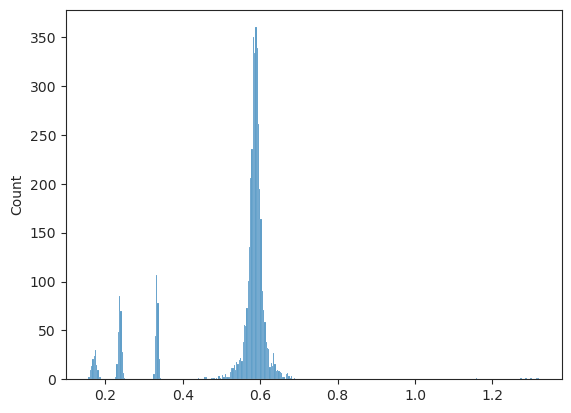

In [10]:
all_norm = torch.cat(vae.all_log_norm)
all_norm = torch.exp(all_norm)
sns.histplot(to_np(all_norm));

In [15]:
sum([len(e) for e in tr.model.all_log_norm])

4199

0

In [40]:
def _cond(global_step, n_iter, freq: int = 4000):
	a = global_step // freq
	b = (global_step - n_iter) // freq
	return a - b == 1

In [41]:
for epoch in range(1000):
    global_step = (epoch + 1) * n_iters
    if _cond(global_step, len(tr.dl_trn)):
        print(global_step)

4056

8034

12012

16068

20046

24024

28002

32058

36036

40014

44070

48048

52026

56004

60060

64038

68016

72072

76050

## Review train options

In [8]:
vars(tr.cfg)

{'lr': 0.1,
 'epochs': 5000,
 'batch_size': 512,
 'warmup_epochs': 500,
 'lambda_init': 10,
 'lambda_norm': 0.01,
 'lambda_anneal': False,
 'kl_const_coeff': 0.0001,
 'kl_const_portion': 0.0001,
 'kl_anneal_portion': 0.3,
 'optimizer': 'adamax',
 'optimizer_kws': {'betas': (0.9, 0.999),
  'weight_decay': 0.0003,
  'eps': 1e-08},
 'scheduler_type': 'cosine',
 'scheduler_kws': {'T_max': 4499.0, 'eta_min': 0.0001},
 'balanced_recon': True,
 'clip_grad': None,
 'chkpt_freq': 10,
 'eval_freq': 5,
 'log_freq': 2}

## Train

In [9]:
tr.train(comment='b512-lr0.1_spectral:reg')

epoch # 5000, avg loss: 0.662515: 100%|██████████| 5000/5000 [5:18:23<00:00,  3.82s/it]  


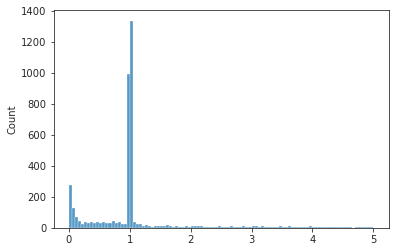

In [12]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0, 5, 101));

In [13]:
np.max(all_norm), (all_norm > 5).sum() / len(all_norm)

(66.75848, 0.08049965301873699)

In [14]:
vae.eval();

In [15]:
x, norm = next(iter(tr.dl_vld))
x, norm = tr.to([x, norm])

In [16]:
with torch.no_grad():
    y, z, log_p, log_q, kl_all, kl_diag = vae(x)

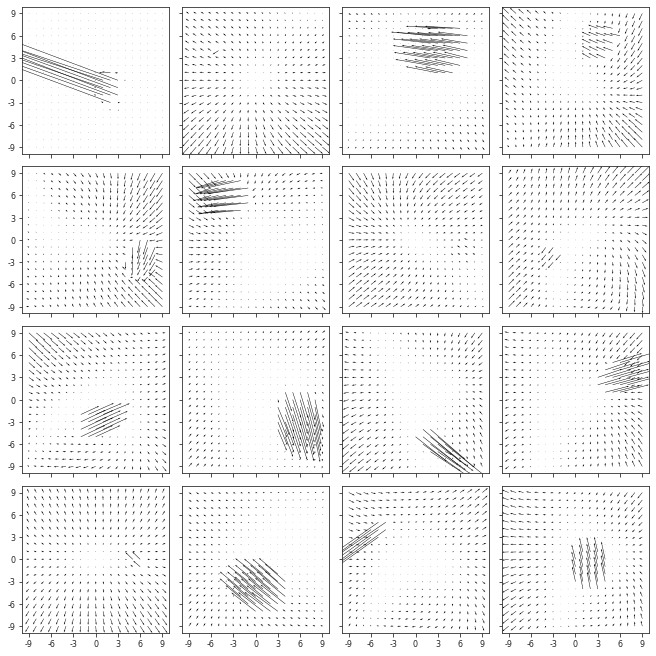

In [17]:
_ = show_opticflow(y)

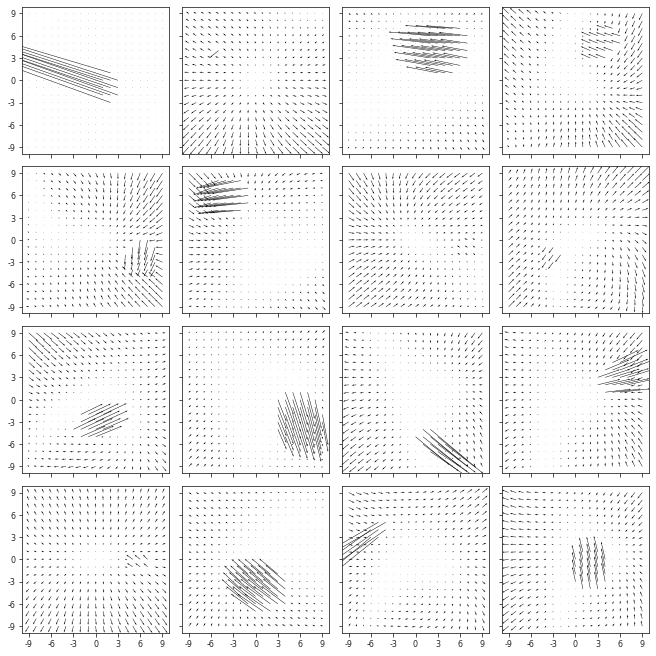

In [18]:
_ = show_opticflow(x)

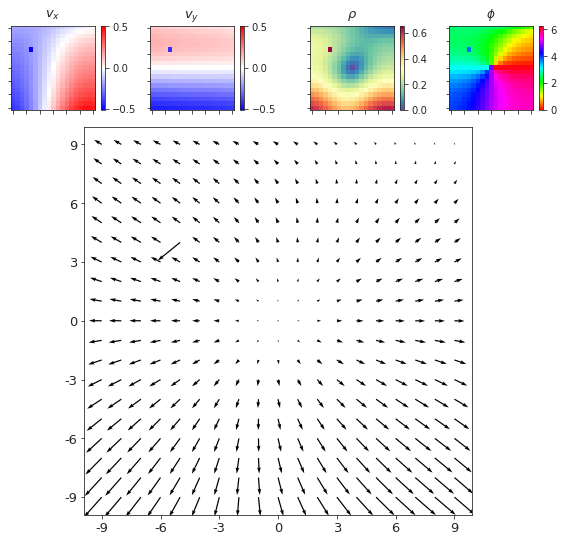

In [16]:
_ = show_opticflow_full(x[1])

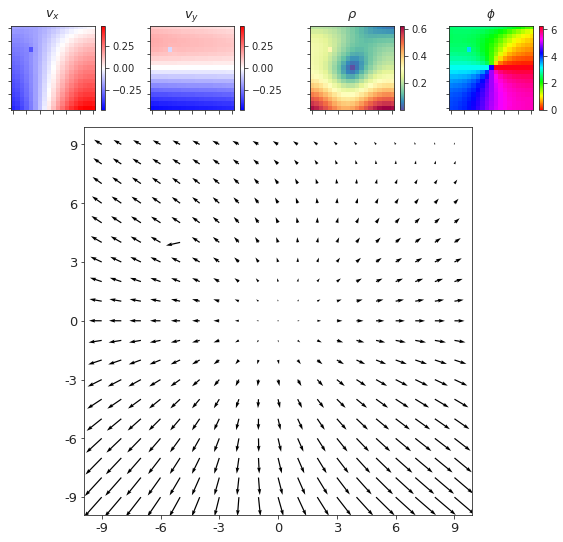

In [17]:
_ = show_opticflow_full(y[1])

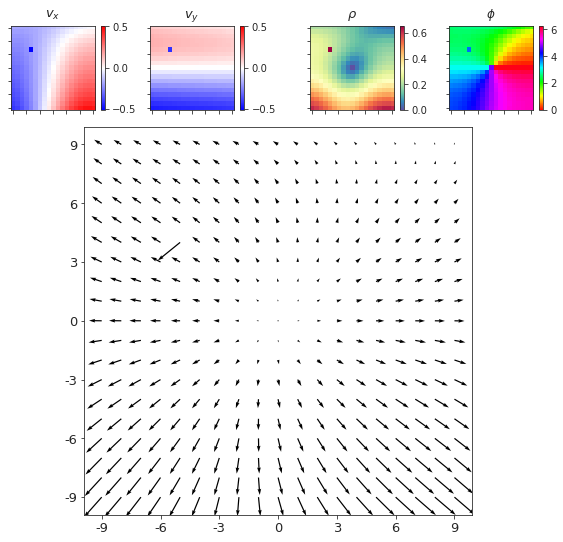

In [18]:
x, _ = tr.dl_vld.dataset[1]
_ = show_opticflow_full(x)

In [19]:
ff = h5py.File(vae.cfg.h_pre)

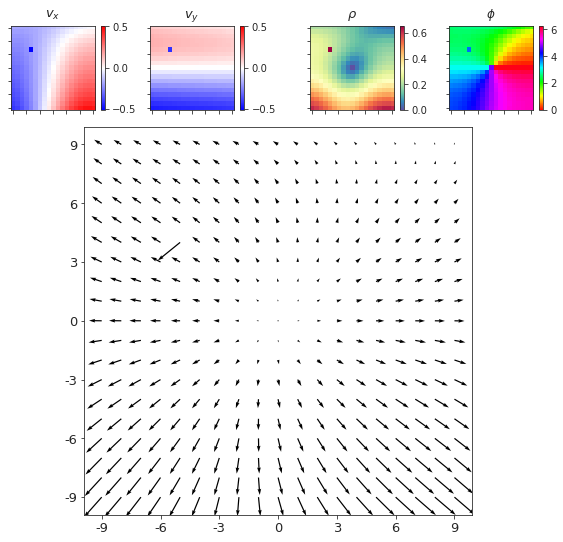

In [20]:
x = np.array(ff['vld']['x'])[1]
_ = show_opticflow_full(x)

In [21]:
np.array(ff['vld']['fix'])[1]

array([-0.1983603 ,  0.77034186])

In [22]:
np.array(ff['vld']['vel_slf'])[:, 1], np.array(ff['vld']['vel_obj'])[:, 1], np.array(ff['vld']['pos_obj'])[:, 1]

(array([-0.29326528,  0.38819782,  0.44032602]),
 array([-0.58997992, -1.05976248,  0.47420269]),
 array([-1.06814914,  1.62296915,  0.84527033]))

In [28]:
with torch.no_grad():
    y_sample, z_sample = vae.sample(1024, 1, device=tr.device)

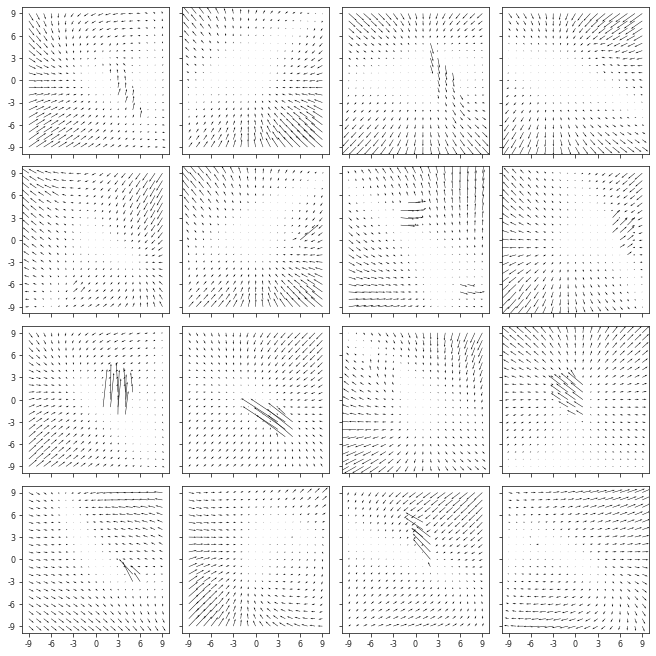

In [29]:
_ = show_opticflow(y_sample)

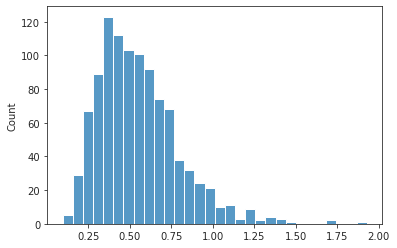

In [39]:
norm_sample = sp_lin.norm(to_np(y_sample), axis=-1).mean(-1).mean(-1)
sns.histplot(norm_sample);

In [40]:
to_np(torch.linalg.vector_norm(vae.stem.weight, dim=[1, 2, 3]))

array([0.9960772 , 0.99464476, 0.9761043 , 0.98463345], dtype=float32)

In [41]:
w = to_np(vae.stem.weight)
w.shape

(4, 2, 4, 4)

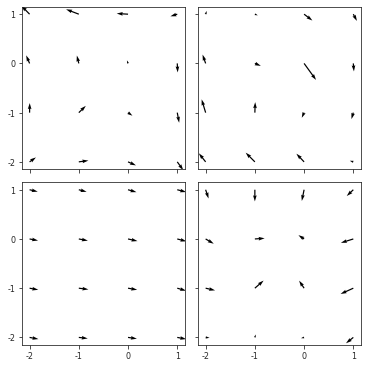

In [42]:
_ = show_opticflow(w, 2, figsize=(5, 5), tick_spacing=1)

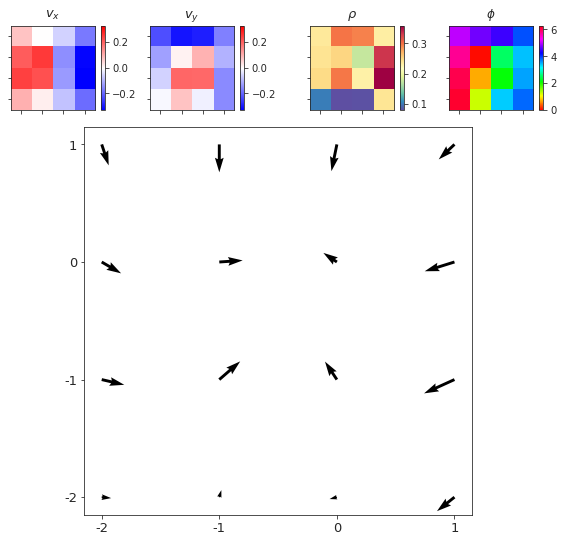

In [43]:
_ = show_opticflow_full(w[3], tick_spacing=1)

In [44]:
vae.enc0

Sequential(
  (0): ELU(alpha=1.0, inplace=True)
  (1): ParametrizedConv2D(
    128, 128, kernel_size=(1, 1), stride=(1, 1)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
      )
    )
  )
  (2): ELU(alpha=1.0, inplace=True)
)

In [21]:
vae.enc_sampler

ModuleList(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ParametrizedLinear(
      in_features=2048, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ParametrizedLinear(
      in_features=4096, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ParametrizedLinear(
      in_features=4096, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ParametrizedLinear(
      in_features=8192, out_features=20, bias=True
      (parametri

In [22]:
vae.dec_sampler

ModuleList(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ELU(alpha=1.0, inplace=True)
    (2): ParametrizedLinear(
      in_features=4096, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ELU(alpha=1.0, inplace=True)
    (2): ParametrizedLinear(
      in_features=4096, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ELU(alpha=1.0, inplace=True)
    (2): ParametrizedLinear(
      in_features=8192, out_features=20, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
  (3): Sequential(
    (0): Flatten(start_d